In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as functional

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
### load npz file
from scipy import sparse
#pots = sparse.load_npz("sparse_matrix_2.npz").toarray().reshape(-1, 1371, 637)
pots = sparse.load_npz("sparse_matrix.npz").toarray().reshape(-1, 256, 256)

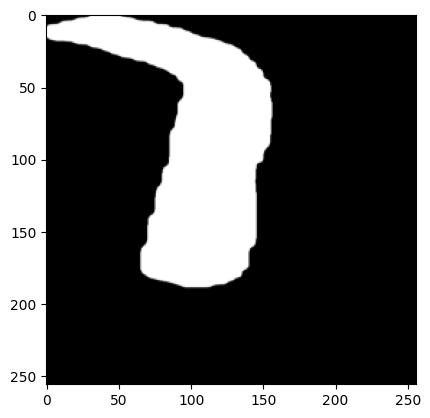

In [31]:
plt.imshow(pots[1], cmap='gray') 

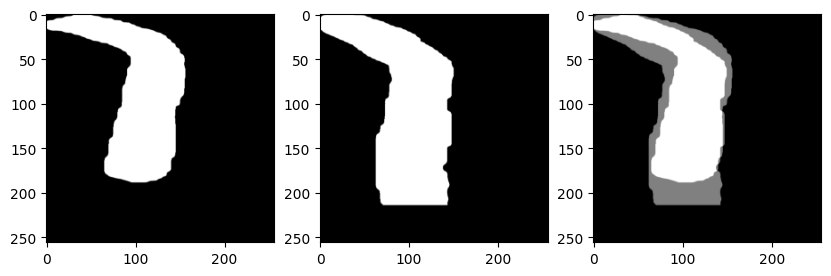

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(pots[1], cmap='gray')
ax[1].imshow(pots[2], cmap='gray')
ax[2].imshow(pots[1] + pots[2], cmap='gray')

In [33]:
my_list = []
for pot in pots:
    max_value = pot.nonzero()[0].max()
    my_list.append(max_value)

In [34]:
df = pd.DataFrame(np.arange(0, len(my_list)), columns=['index'])

In [35]:
my_list

[131,
 190,
 215,
 199,
 165,
 80,
 124,
 106,
 67,
 67,
 177,
 159,
 161,
 168,
 187,
 188,
 157,
 148,
 147,
 114,
 89,
 95,
 123,
 76,
 97,
 155,
 135,
 171,
 118,
 170,
 144,
 126,
 93,
 158,
 144,
 159,
 149,
 113,
 88,
 120,
 178,
 91,
 204,
 104,
 149,
 107,
 172,
 117,
 184,
 178,
 109,
 151,
 80,
 79,
 103,
 90,
 141,
 146,
 117,
 83,
 101,
 126,
 136,
 83,
 107,
 129,
 90,
 114,
 87,
 112,
 130,
 117,
 99,
 91,
 67,
 91,
 87,
 99,
 145,
 75,
 136,
 98,
 110,
 104,
 103,
 110,
 109,
 104,
 115,
 112,
 112,
 112,
 168,
 189,
 169,
 108,
 145,
 210,
 218,
 135,
 132,
 129,
 195,
 255,
 145,
 113,
 102,
 112,
 104,
 81,
 103,
 157,
 144,
 112,
 143,
 92,
 158,
 136,
 120,
 73,
 208,
 168,
 131,
 114,
 128,
 192,
 94,
 98,
 131,
 157,
 129,
 146,
 168,
 117,
 112,
 93,
 193,
 168,
 112,
 193,
 140,
 181,
 86,
 115,
 115,
 75,
 115,
 139,
 101,
 173,
 182,
 108,
 153,
 117,
 103,
 142,
 122,
 77,
 131,
 119,
 106,
 130,
 145,
 194,
 207,
 98,
 99,
 177,
 104,
 89,
 89,
 98,
 88,
 1

In [36]:
df["conservation"] = my_list

In [37]:
df

index  conservation
0        0           131
1        1           190
2        2           215
3        3           199
4        4           165
..     ...           ...
307    307           111
308    308            94
309    309           126
310    310           136
311    311           125

[312 rows x 2 columns]

In [38]:
np.array(my_list).min()

67

In [39]:
pots[0].nonzero()[0].max()

131

In [40]:
min_pots = pots[:, :np.array(my_list).min(), :]

In [41]:
### create a grid of images

def show_grid(images, nrow=8):
    img = make_grid(images, nrow=nrow)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

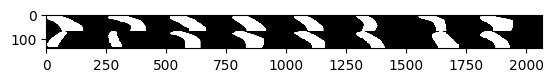

In [42]:
show_grid(torch.tensor(min_pots[:16]).unsqueeze(1))

In [43]:
BATCH_SIZE = 64
EPOCHS = 80
LEARNING_RATE = 0.001
IMG_SIZE = 256
LATENT_DIMS = 10
LOSS_FN = F.mse_loss
SAVE_MODEL = False

In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(1),])

In [45]:
trn, tst = train_test_split(pots, test_size=0.20)
print("Train size:  "+ str(len(trn)))
print("Test size:  "+ str(len(tst)))

Train size:  249
Test size:  63


In [46]:
class PotdsTorchUnsupervised(Dataset):
    
    def __init__(self, selected_pots, transform=None):
        self.selected_pots = selected_pots
        self.transform = transform
    
    def __len__(self):
        return len(self.selected_pots)

    def __getitem__(self,index):
        pot = self.selected_pots[index]

        if self.transform:
            pot = self.transform(pot)
        return pot

In [47]:
potds_pytorch_trn = PotdsTorchUnsupervised(trn, transform=transform)
potds_pytorch_tst = PotdsTorchUnsupervised(tst, transform=transform)
potds_pytorch = PotdsTorchUnsupervised(pots, transform=transform)

In [48]:
data_loader_train = DataLoader(dataset = potds_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset = potds_pytorch_tst, batch_size=BATCH_SIZE, shuffle=True)
data_loader_eval = DataLoader(dataset = potds_pytorch, batch_size=16, shuffle=False)

In [49]:
x= next(iter(data_loader_train))
x.shape

c:\Users\larth\.conda\envs\aippa_dev\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([64, 1, 256, 256])

In [50]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize = (10,10),ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = functional.to_pil_image(img.float())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

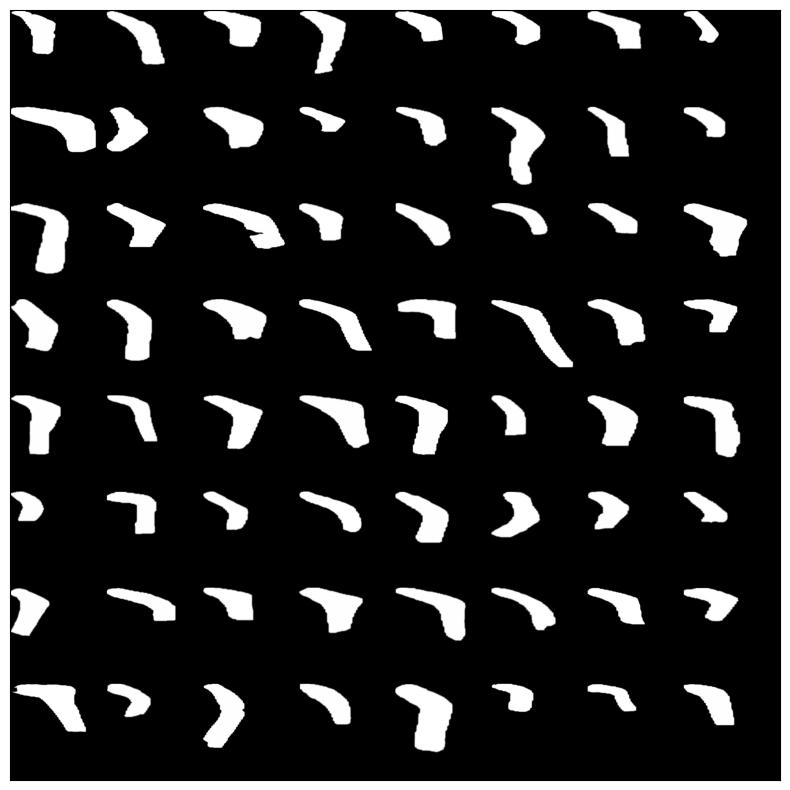

In [51]:
im = make_grid(x, nrow=8)
show(im)

In [52]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()  
        self.latent_dims = latent_dims
        self.encoder = nn.Sequential( #256*256
            nn.Conv2d(1, 8,  kernel_size = 3, stride=2, padding=1), #128*128
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size = 3, stride=2, padding=1), #64*64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size = 3, stride=2, padding=1), #32*32
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size = 3, stride=2, padding=1), #16*16
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size = 3, stride=2, padding=1), #8*8
            nn.Flatten(),
            nn.ReLU(True),
            nn.Linear(8*8*128, 128),
            ) 
        
        self.z_mean = torch.nn.Linear(128, latent_dims)
        self.z_log_var = torch.nn.Linear(128, latent_dims)
           
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 8 * 8 * 128),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride=2, padding=1, output_padding=1), #16*16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride=2, padding=1, output_padding=1),# 32*32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride=2, padding=1, output_padding=1), # 64*64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size= 3, stride=2, padding=1, output_padding=1), #128*128
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size = 3, stride=2, padding=1, output_padding=1), #256*256
            nn.Sigmoid()
            )
            
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

    def sample(self, n_samples):
      z = torch.randn((n_samples, self.latent_dims)).to(device)
      return self.decoder(z)

In [53]:
vae = VariationalAutoencoder(latent_dims=LATENT_DIMS)

In [54]:
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
reconstruction_term_weight = 1 

In [55]:
vae.to(device)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=8192, out_features=128, bias=True)
  )
  (z_mean): Linear(in_features=128, out_features=10, bias=True)
  (z_log_var): Linear(in_features=128, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplac

In [56]:
outputs_train = []
losses_train = []
for epoch in range(EPOCHS):
        vae.train()
        for batch_idx, img in enumerate(data_loader_train):
                
                img = img.to(device)
                encoded, z_mean, z_log_var, decoded = vae(img.float())
                
                kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) 

                batchsize = kl_div.size(0)
                kl_div = kl_div.mean() 

                pixelwise = LOSS_FN(decoded * (img != 0).float(), img.float(), reduction='none')

                #loss = criterion(outputs * (target != 0).float(), target)

                pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)
                pixelwise = pixelwise.mean()

                loss = reconstruction_term_weight*pixelwise + kl_div

                optimizer.zero_grad()

                loss.backward()

                optimizer.step()

        if epoch % 5 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}], Loss : {loss.item():.4f}")
        
        outputs_train.append((epoch, img, decoded))
        losses_train.append((epoch, loss.item()))
        loss_train = np.array(losses_train)

Epoch [1/80], Loss : 1877.8264
Epoch [6/80], Loss : 1093.8615
Epoch [11/80], Loss : 749.1230
Epoch [16/80], Loss : 618.0710
Epoch [21/80], Loss : 551.1684
Epoch [26/80], Loss : 526.9894
Epoch [31/80], Loss : 491.0477
Epoch [36/80], Loss : 470.3476
Epoch [41/80], Loss : 426.2140
Epoch [46/80], Loss : 374.1528
Epoch [51/80], Loss : 327.9795
Epoch [56/80], Loss : 335.2939
Epoch [61/80], Loss : 281.4107
Epoch [66/80], Loss : 230.0391
Epoch [71/80], Loss : 239.5760
Epoch [76/80], Loss : 220.1362


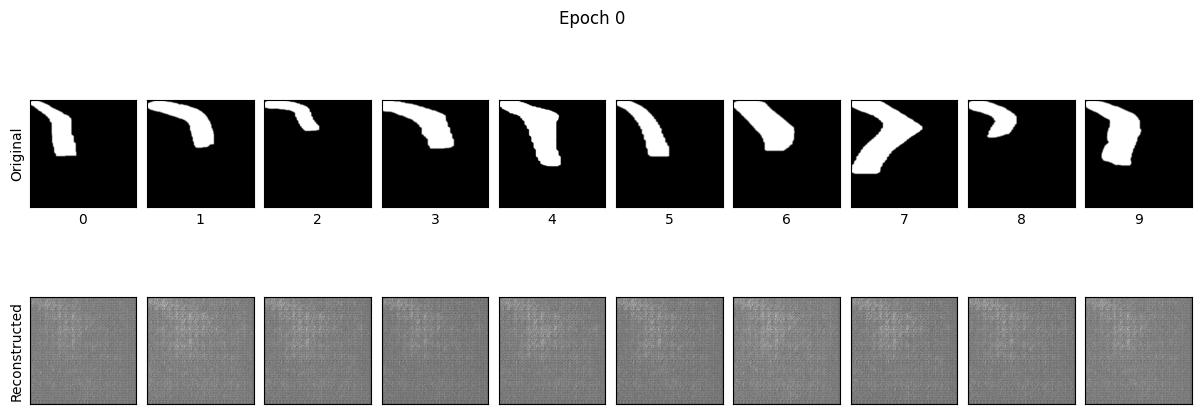

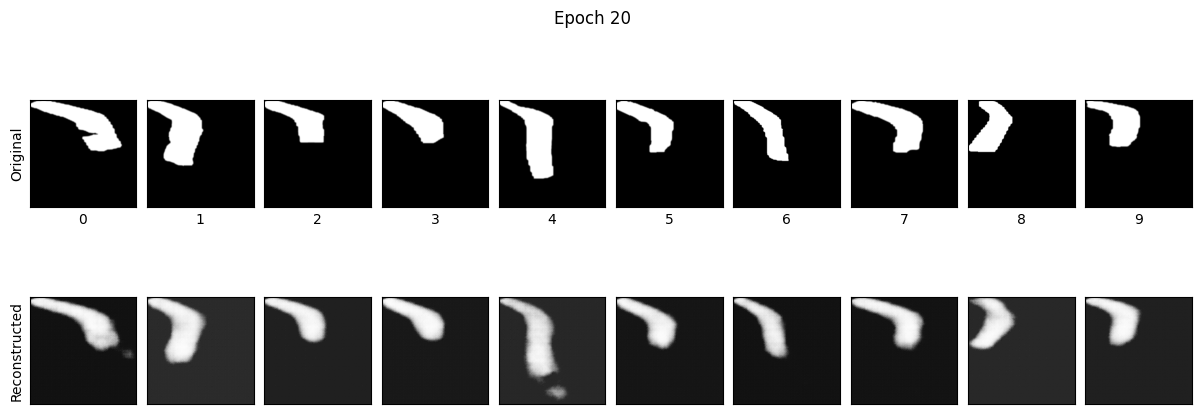

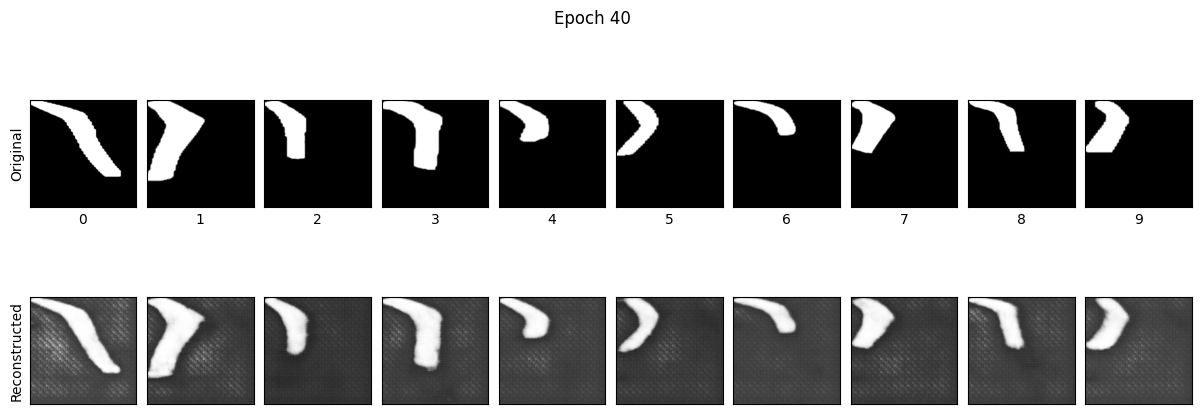

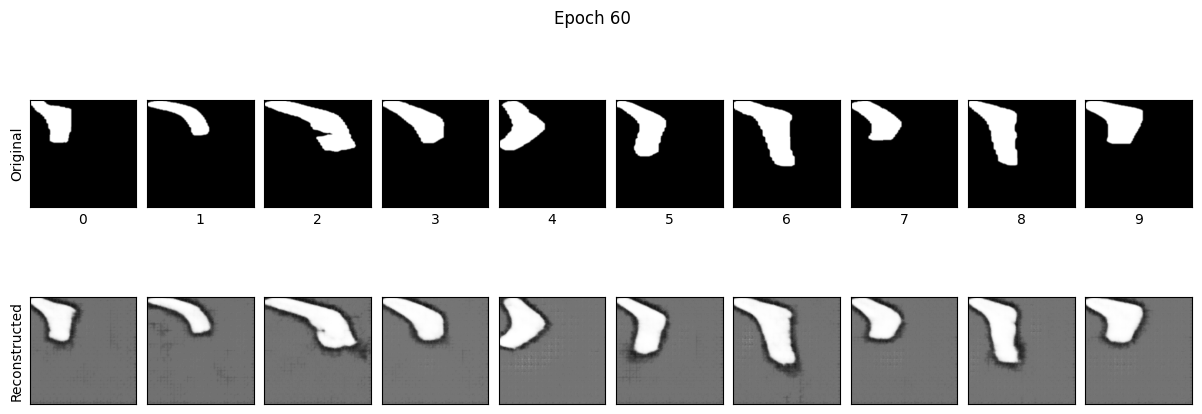

In [57]:
for k in range(0, EPOCHS, 20):


    imgs = outputs_train[k][1].to("cpu").detach().numpy()
    recon = outputs_train[k][2].to("cpu").detach().numpy()

    plt_number = 10

    fig, ax = plt.subplots(2, int(plt_number), figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.05, wspace=0.1))
    plt.suptitle(f"Epoch {k}")
    for i in range(int(plt_number)):
        ax[0, i].imshow(np.transpose(imgs[i], (1,2,0)), cmap='binary_r')
        ax[1, i].imshow(np.transpose(recon[i],(1,2,0)), cmap='binary_r')
        ax[0, i].set_xlabel(i)
        ax[0, 0].set_ylabel('Original')
        ax[1, 0].set_ylabel('Reconstructed')

In [58]:
outputs_tst = []
losses_tst = []

with torch.no_grad():
    for epoch in range(EPOCHS):
        for i, img in enumerate(data_loader_test):
            img = img.to(device)
            encoded, z_mean, z_log_var, decoded = vae(img.float())
                
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1)

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() 

            #pixelwise = LOSS_FN(decoded, img.float(), reduction='none')

            pixelwise = LOSS_FN(decoded * (img != 0).float(), img.float(), reduction='none')
            
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)
            pixelwise = pixelwise.mean() 

            loss = reconstruction_term_weight*pixelwise + kl_div
        outputs_tst.append((epoch, img, decoded))
        losses_tst.append((epoch, loss.item()))
        loss_tst = np.array(losses_tst)
    print(f"Mean test loss: {np.mean(loss_tst[0][1]):.2f}")

Mean test loss: 618.34


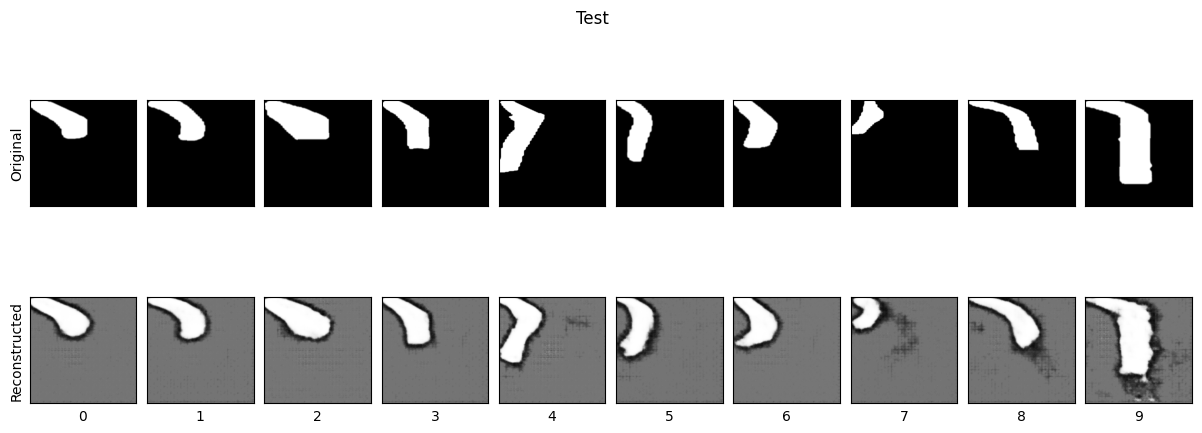

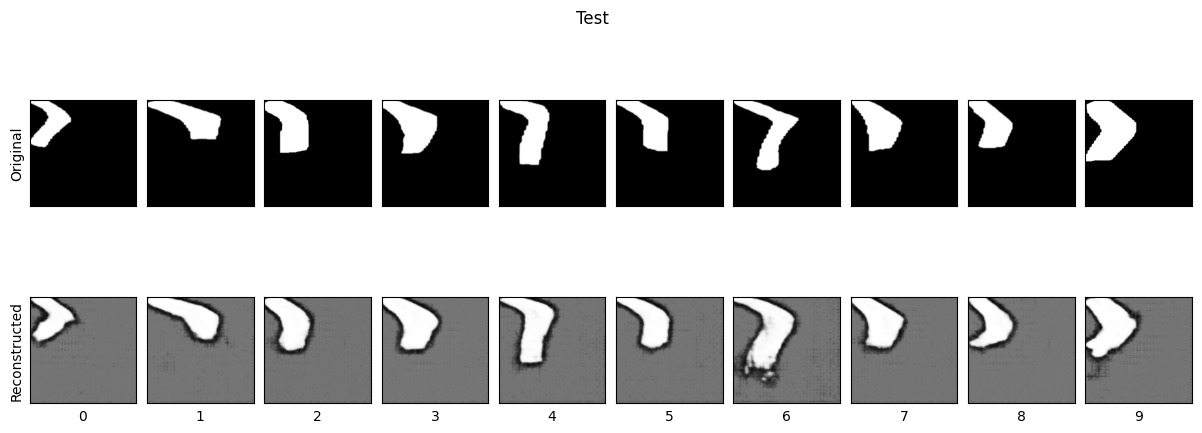

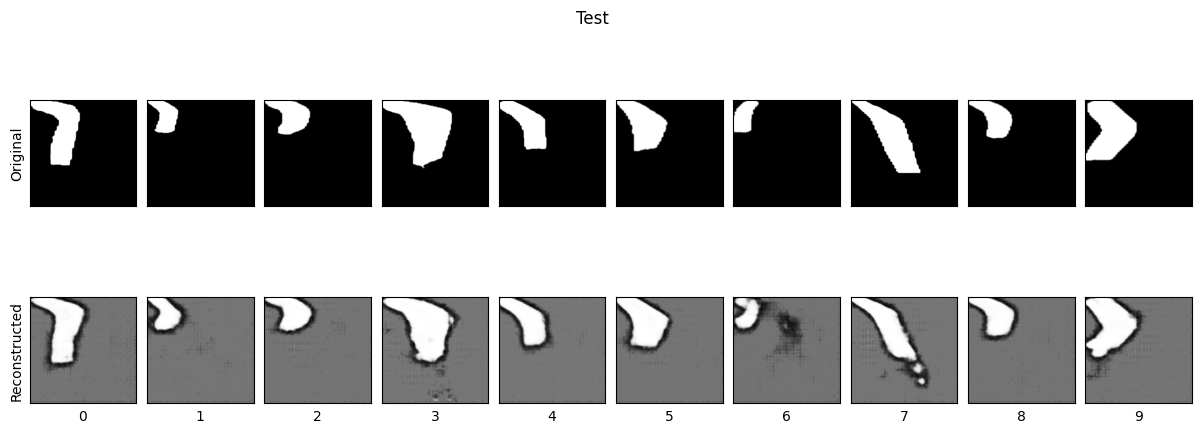

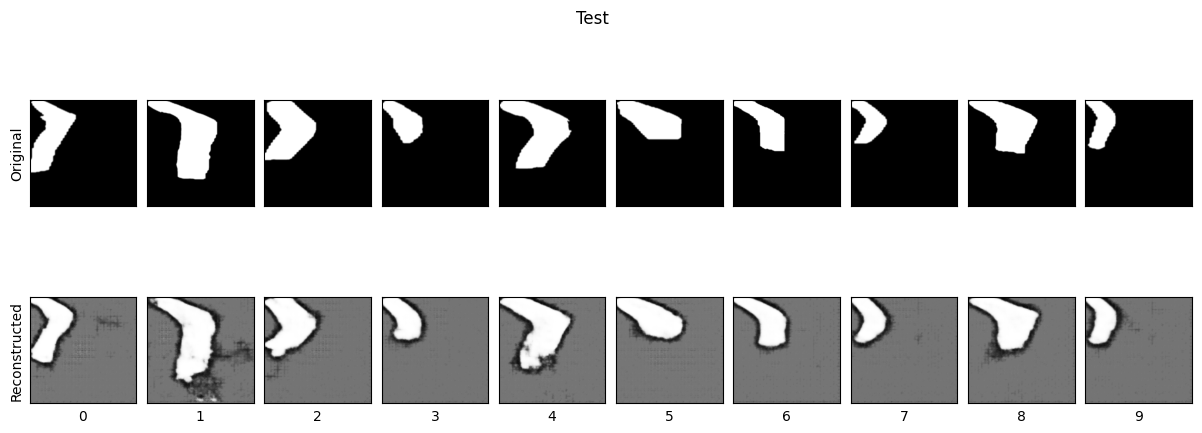

In [59]:
for k in range(0, EPOCHS, 20):
    imgs = outputs_tst[k][1].to("cpu").detach().numpy()
    recon = outputs_tst[k][2].to("cpu").detach().numpy()
            
    plt_number = 10

    fig, ax = plt.subplots(2, plt_number, figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.05, wspace=0.1))
    plt.suptitle(f"Test")
    for i in range(plt_number):
            ax[0, i].imshow(np.transpose(imgs[i], (1,2,0)), cmap='binary_r')
            ax[1, i].imshow(np.transpose(recon[i],(1,2,0)), cmap='binary_r')
            ax[0, 0].set_ylabel('Original')
            ax[1, 0].set_ylabel('Reconstructed')
            ax[1, i].set_xlabel(i)

In [60]:
encoded_samples = []
decoded_imgs = []
for b, img in enumerate(data_loader_eval):
    img = img.to(device)
    vae.to(device)
    vae.eval()
    with torch.no_grad():
        encoded_img, _, _, decoded  = vae(img.float())
        encoded_img = encoded_img.cpu().numpy()
        decoded = decoded.cpu().numpy()
    encoded_samples.extend(encoded_img)
    decoded_imgs.extend(decoded)

    encoded_dim = np.array(encoded_samples)
    decoded_images = np.array(decoded_imgs)
    decoded_images = np.transpose(decoded_imgs, (0, 2,3,1))

In [61]:
import pandas as pd

In [62]:
encoded_df = pd.DataFrame(encoded_dim)

In [63]:
from aippa.dimensionalityreduction import AippaUmap

c:\Users\larth\.conda\envs\aippa_dev\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\larth\.conda\envs\aippa_dev\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\larth\.conda\envs\aippa_dev\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning:

The 'nopy

In [64]:
ump = AippaUmap(x = encoded_df, n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42, n_epochs=500, learning_rate=0.1, init='spectral', spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, angular_rp_forest=False, target_n_neighbors=-1, target_metric='categorical', target_weight=0.5, transform_seed=42, verbose=False)

In [65]:
from aippa.visualization import ScatterImage

In [66]:
### create a df with the index of the images

df = pd.DataFrame(np.arange(0, len(pots)), columns=['index'])

In [67]:
ScatterImage(ump.reduction, info_selected = df, potds = pots, output="notebook")

Loading BokehJS ...

c:\users\larth\documents\reconstruction_pots\appendix_a\aippa\src\aippa\visualization.py:205: UserWarning:


You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.




In [68]:
from aippa.dimensionalityreduction import PrincipalComponentAnalysis

In [69]:
pca = PrincipalComponentAnalysis(encoded_dim, 2)

Original dimension: (312, 10)
Output dimension: (312, 2)
First 5 components variance: [0.23 0.17]


In [70]:
import seaborn as sns

In [71]:
def plot_reconstructed(decoder, r0=(min(pca.reduction[:,0]), max(pca.reduction[:,0])), r1=(min(pca.reduction[:,1]), max(pca.reduction[:,1])), n=20):
    fig = plt.figure(figsize=(50,10))
    w = 256
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to("cpu")
            vae.to("cpu")
            z = torch.Tensor(pca.method.inverse_transform(z))
            x_hat = decoder(z)
            x_hat = x_hat.reshape(256, 256).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')
    sns.scatterplot(x=pca.reduction[:,0], y=pca.reduction[:,1], legend=True, c = 'red', alpha=0.5, s=100)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

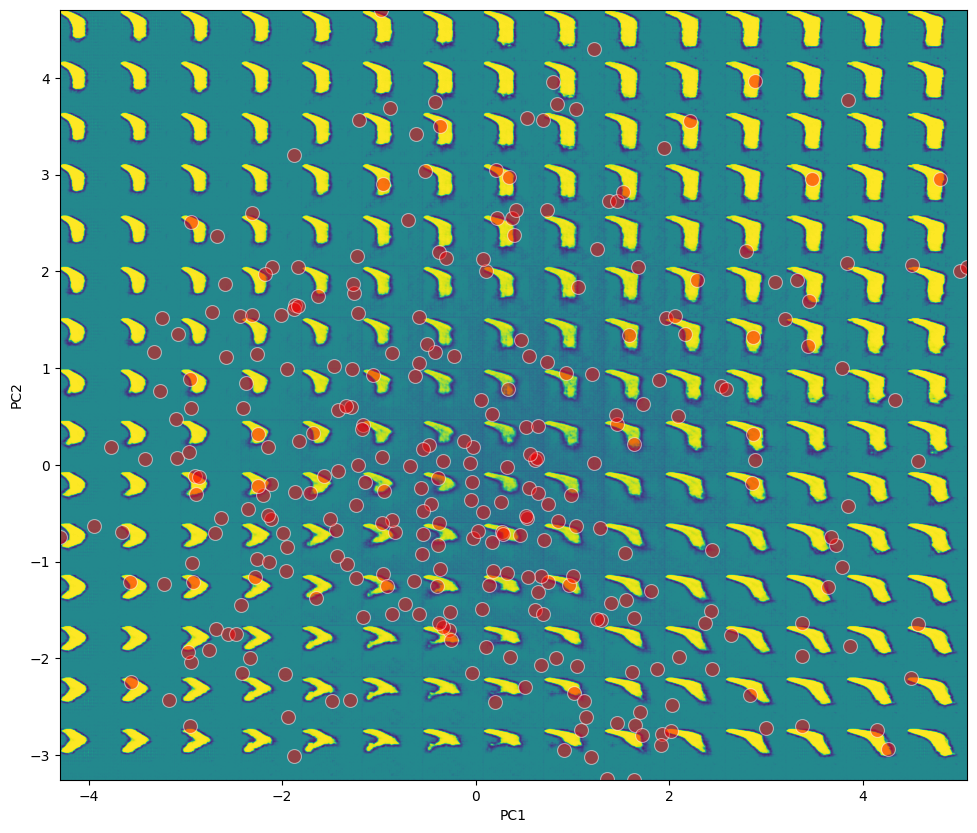

In [72]:
plot_reconstructed(vae.decoder, n=15)

In [73]:
encoded_df["conservation"] = my_list

<Axes: >

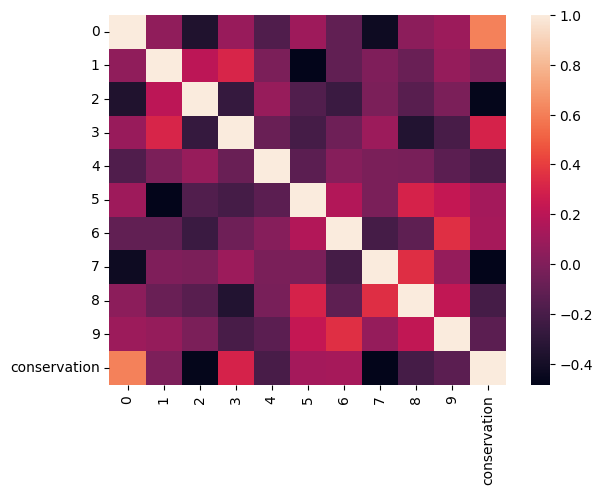

In [74]:
sns.heatmap(encoded_df.corr(method="spearman"), annot=False)

In [75]:
abs(encoded_df.corr(method="spearman")["conservation"]).sort_values(ascending=False)

conservation    1.000000
0               0.607910
7               0.479579
2               0.468661
3               0.299109
8               0.212998
4               0.200356
9               0.134505
6               0.129230
5               0.120624
1               0.012415
Name: conservation, dtype: float64

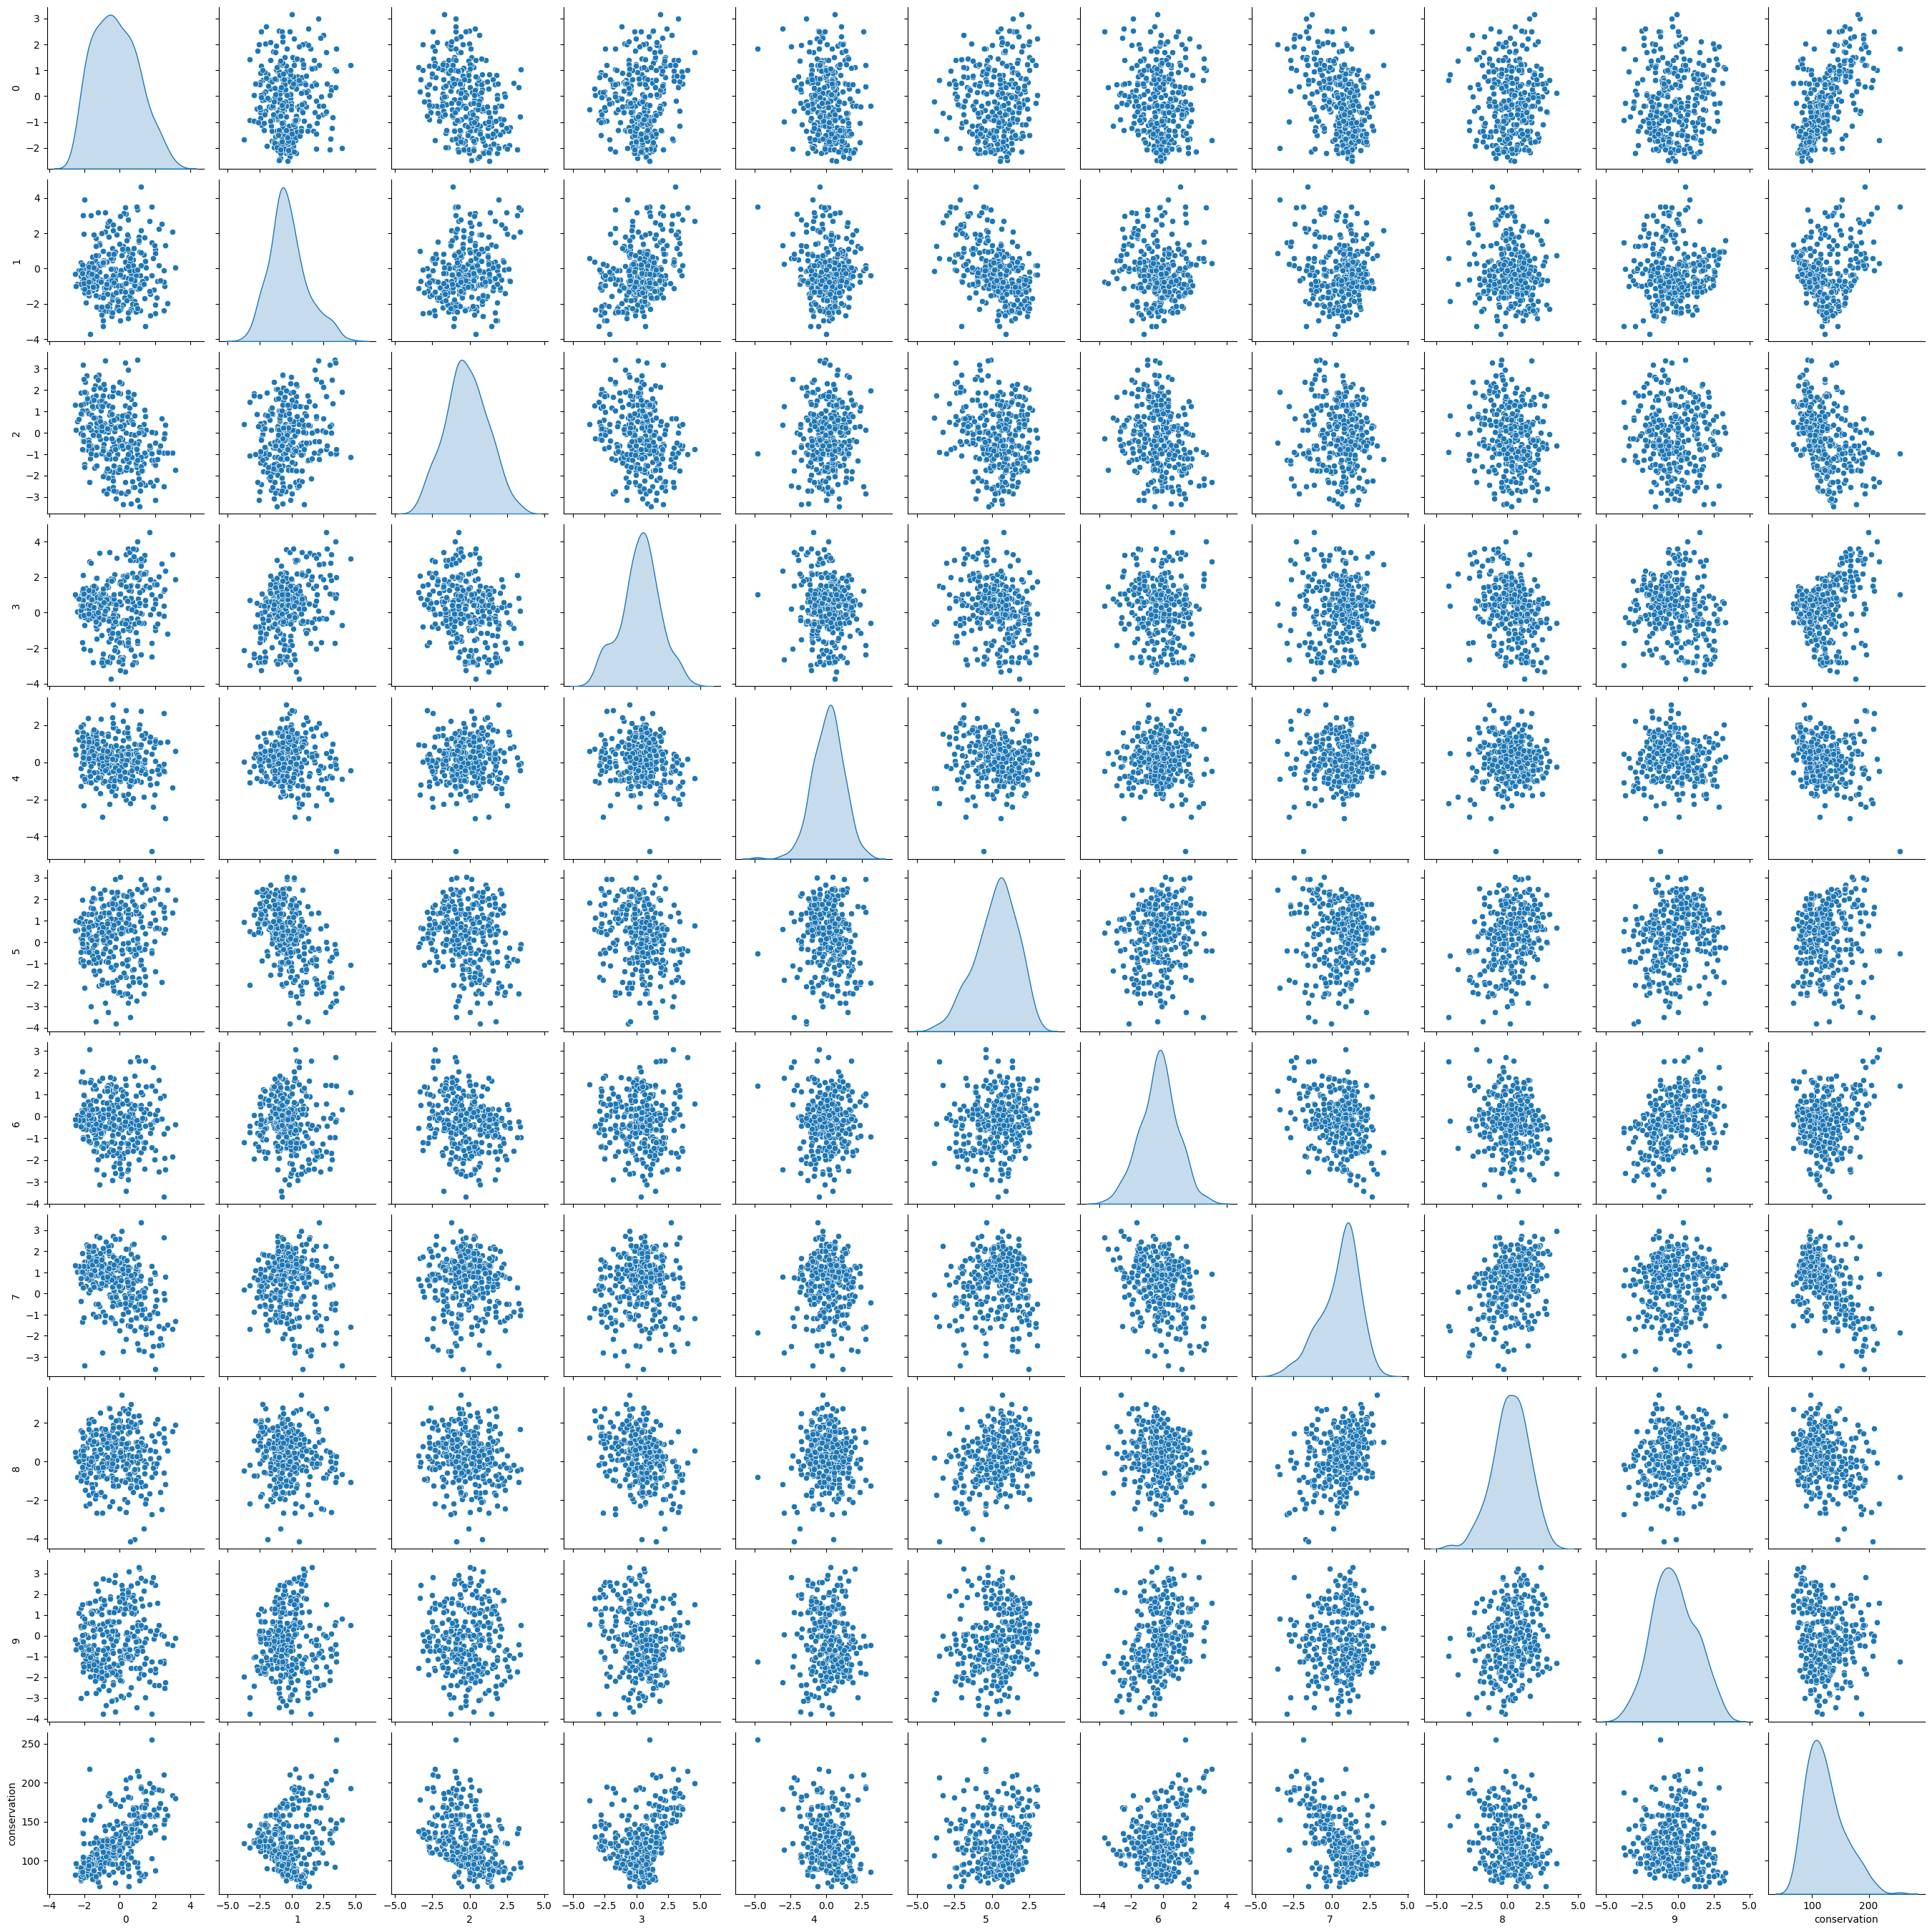

In [90]:
sns.pairplot(encoded_df, diag_kind='kde')

In [81]:
#encoded_df_no_correlated = encoded_df.drop([3, 4, 18, 10, 12, 8], axis=1).drop("conservation", axis=1)
encoded_df_no_correlated = encoded_df[[0,7,2]]#.drop("conservation", axis=1)

In [82]:
from umap import UMAP

In [83]:
ump = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(encoded_df_no_correlated)

In [84]:
df.loc[encoded_df_no_correlated.index]

index
0        0
1        1
2        2
3        3
4        4
..     ...
307    307
308    308
309    309
310    310
311    311

[312 rows x 1 columns]

<Axes: xlabel='0', ylabel='7'>

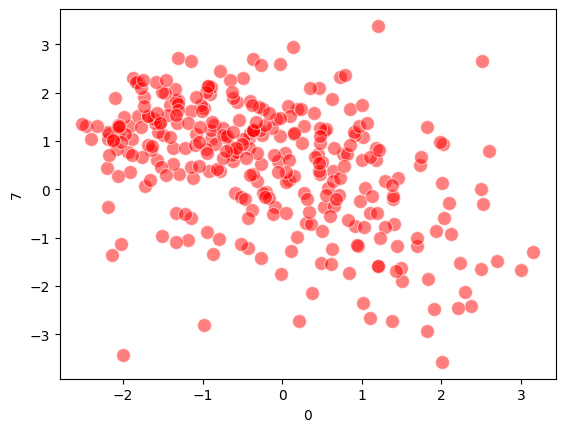

In [87]:
sns.scatterplot(x=encoded_df[0], y=encoded_df[7], legend=True, c = 'red', alpha=0.5, s=100)

In [85]:
ScatterImage(ump, info_selected = df.loc[encoded_df_no_correlated.index], potds = pots, output="notebook")

Loading BokehJS ...

c:\users\larth\documents\reconstruction_pots\appendix_a\aippa\src\aippa\visualization.py:205: UserWarning:


You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.




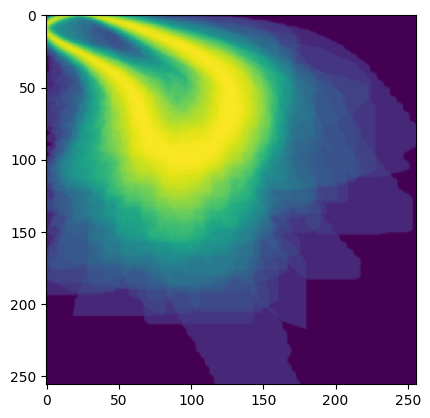

In [94]:
plt.imshow(np.std(pots, axis=0))